# Analysis of Gridded Ensemble Precipitation Estimates over Australia

In this notebook we work with several ensemble members of precipitation data. The analysis we do below is quite simple but the problem is a good illustration of a common task in the atmospheric sciences. 

* Open dataset
* Average seasonal precipitation
* Extract a time series of annual maximum precipitation events over a region

The following material uses Coupled Model Intercomparison Project (CMIP6) collections. The CMIP6 terms of use are found [here](https://pcmdi.llnl.gov/CMIP6/TermsOfUse/TermsOfUse6-1.html). For more information on the collection, please click [here]( https://geonetwork.nci.org.au/geonetwork/srv/eng/catalog.search#/metadata/f6600_2266_8675_3563).

---

- Authors: NCI Virtual Research Environment Team
- Keywords: CMIP6, xarray, dask, precipitation
- Create Date: 2020-April

### Prerequisite

To run this notebook on Gadi/VDI, or on your local computer. The following modules are needed:

* Xarray

You also need to be a member of the following data project:

* fs38

You can request to join the project through [NCI's user account management system](https://my.nci.org.au). 

### Setup

In [1]:
from dask.distributed import Client,LocalCluster
client = Client(scheduler_file='scheduler.json')
print(client)

<Client: 'tcp://10.6.56.71:8720' processes=24 threads=24, memory=103.08 GB>


/apps/pangeo/2020.05/lib/python3.7/site-packages/distributed/client.py:1079: VersionMismatchWarning: Mismatched versions found

numpy
+------------------------+---------+
|                        | version |
+------------------------+---------+
| client                 | 1.18.4  |
| scheduler              | 1.18.4  |
| tcp://10.6.56.71:33383 | 1.17.2  |
| tcp://10.6.56.71:34133 | 1.17.2  |
| tcp://10.6.56.71:34239 | 1.17.2  |
| tcp://10.6.56.71:34715 | 1.17.2  |
| tcp://10.6.56.71:34795 | 1.17.2  |
| tcp://10.6.56.71:35221 | 1.17.2  |
| tcp://10.6.56.71:35647 | 1.17.2  |
| tcp://10.6.56.71:35823 | 1.17.2  |
| tcp://10.6.56.71:36449 | 1.17.2  |
| tcp://10.6.56.71:36851 | 1.17.2  |
| tcp://10.6.56.71:36889 | 1.17.2  |
| tcp://10.6.56.71:36919 | 1.17.2  |
| tcp://10.6.56.71:37721 | 1.17.2  |
| tcp://10.6.56.71:38919 | 1.17.2  |
| tcp://10.6.56.71:39561 | 1.17.2  |
| tcp://10.6.56.71:39685 | 1.17.2  |
| tcp://10.6.56.71:39895 | 1.17.2  |
| tcp://10.6.56.71:41575 | 1.17.2  |
| tcp://10.6.56

In [2]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
!ls /g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/

r1i1p1f1  r2i1p1f1  r3i1p1f1


### Open Dataset

Here we load the historical precipitation data of the CESM2 model within the CMIP6 archive. 

The dataset has dimensions of time, latitude, longitude, and ensemble members.

In [4]:
EnsNum=2
DS=[]
for i in range(1,EnsNum+1): #loop through ensemble members
    #concatenate data on time coordinate
    data=xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r'+str(i)+'i1p1f1/day/pr/gn/v*/pr_day_ACCESS-CM2_historical_r'+str(i)+'i1p1f1_gn_*.nc',combine='nested', concat_dim='time' )
    DS.append(data)

In [5]:
ds=xr.concat([DS[i] for i in range(EnsNum)],'ensemble')

### Intra-ensemble range

We calculate the intra-ensemble range for all the mean daily temperature in this dataset.  This gives us a sense of uncertainty.

In [6]:
pr_mean = ds['pr'].mean(dim='time')
spread = (pr_mean.max(dim='ensemble')
        - pr_mean.min(dim='ensemble'))
spread

<xarray.DataArray 'pr' (lat: 144, lon: 192)>
dask.array<sub, shape=(144, 192), dtype=float32, chunksize=(144, 192), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38

### Calling compute
The expressions above didn't actually compute anything. They just build the task graph. To do the computations, we call the `compute` or `persist` methods:

In [21]:
spread = spread.persist()

In [7]:
spread.load

<bound method DataArray.load of <xarray.DataArray 'pr' (lat: 144, lon: 192)>
dask.array<sub, shape=(144, 192), dtype=float32, chunksize=(144, 192), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38>

#### Figure: Intra-ensemble range


Text(0.5, 1.0, 'Intra-ensemble range in mean annual precipitation')

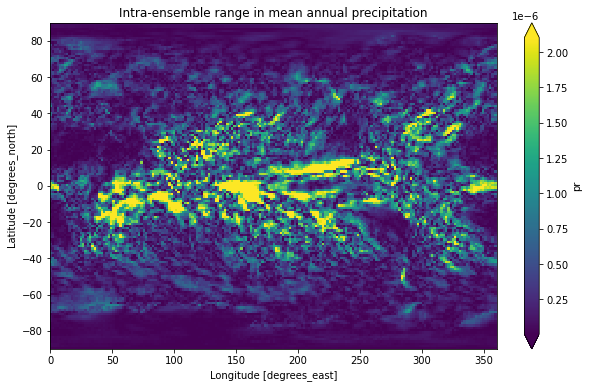

In [8]:
spread.plot(robust=True, figsize=(10, 6))
plt.title('Intra-ensemble range in mean annual precipitation')

### Average seasonal precipitation

We can compute a crude estimate of average seasonal precipitation variables in our dataset. Here, we'll look at the first 4 ensemble members and make some maps of the seasonal total precipitation in each ensemble member.

In [9]:
da_pr = ds['pr'].resample(time='QS-MAR').sum('time')
seasonal_pr = da_pr.isel(ensemble=slice(0, 2)).groupby('time.season').mean('time').persist()
#progress(seasonal_pr)

In [10]:
# properly sort the seasons
seasonal_pr = seasonal_pr.sel(season=['DJF', 'MAM','JJA', 'SON'])
seasonal_pr

<xarray.DataArray 'pr' (ensemble: 2, season: 4, lat: 144, lon: 192)>
dask.array<getitem, shape=(2, 4, 144, 192), dtype=float32, chunksize=(1, 1, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
Dimensions without coordinates: ensemble

#### Figure: Average seasonal precipitation totals 

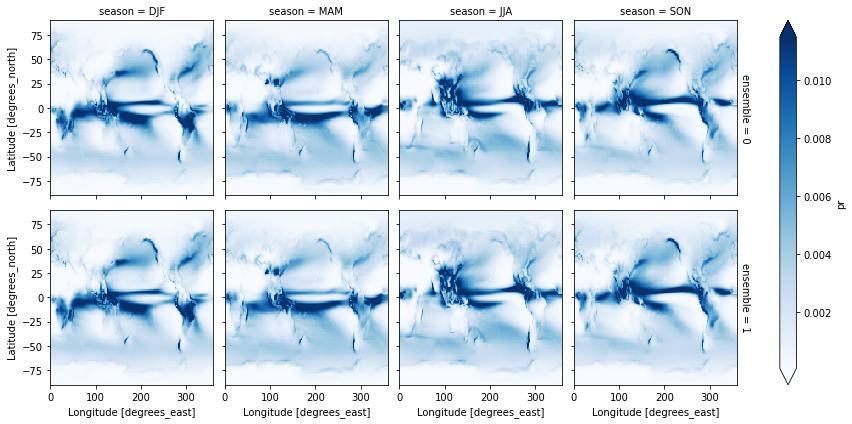

In [11]:
seasonal_pr.plot.pcolormesh(col='season', row='ensemble', cmap='Blues', robust=True)

### Extract a time series of annual maximum precipitation events over a region

In the previous two examples, we've mostly reduced the time and/or ensemble dimension. Here, we'll do a reduction operation on the spatial dimension to look at a time series of extreme precipitation events near Sydney, AU (33.51° S, 9151.12° E).

In [12]:
buf = 0.25  # look at Sydney +/- 0.25 deg

ds_tx = ds.sel(lon=slice(151.12-buf, 151.12+buf), lat=slice(-33.51-buf, 33.51+buf))

In [13]:
pcp_ann_max = ds_tx['pr'].resample(time='AS').max('time')

In [ ]:
pcp_ann_max_ts = pcp_ann_max.max(('lat', 'lon')).persist()
#progress(pcp_ann_max_ts)

#### Figure: Timeseries of maximum precipitation near Sydney, AU.

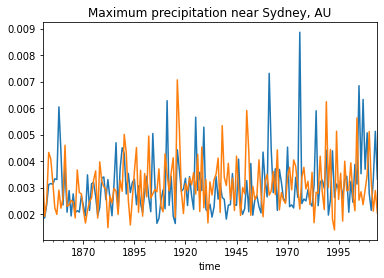

In [16]:
ax = pcp_ann_max_ts.transpose().to_pandas().plot(title='Maximum precipitation near Sydney, AU', legend=False)

### Close the client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [ ]:
client.close()

## Reference

This example is modified from https://github.com/pangeo-data/pangeo-example-notebooks/blob/master/xarray-data.ipynb